# Smart Logistics Supply Chain 

The project performs a wide range of tasks, including exploratory data analysis (EDA), clustering, association rule mining, anomaly detection, shipment status prediction, and inventory level optimization. The focus is on Supply Chain Optimization specifically.

#### Dataset Description

The dataset provides real-time data for smart logistics operations over the past year (2024). It includes information on asset tracking, inventory levels, shipment statuses, environmental conditions, traffic, and user behaviors. The data is enriched with IoT sensor data, such as temperature, humidity, and asset utilization, to facilitate advanced logistics optimization and decision-making.

#### **Key Features**

- **Timestamp**: Date and time of logistics activity.
- **Asset_ID**: Unique identifier for logistical assets (e.g., trucks).
- **Latitude & Longitude**: Geographical coordinates for asset tracking.
- **Inventory_Level**: Current inventory level associated with the asset or shipment.
- **Shipment_Status**: Status of the shipment (e.g., In Transit, Delivered, Delayed).
- **Temperature**: Temperature recorded during transportation.
- **Humidity**: Humidity level at the time of recording.
- **Traffic_Status**: Current traffic condition (e.g., Clear, Heavy, Detour).
- **Waiting_Time**: Time spent waiting during logistics (in minutes).
- **User_Transaction_Amount**: Monetary amount associated with user transactions.
- **User_Purchase_Frequency**: Frequency of purchases made by the user.
- **Logistics_Delay_Reason**: Reason for delays (e.g., Weather, Mechanical Failure).
- **Asset_Utilization**: Percentage of asset utilization.
- **Demand_Forecast**: Predicted demand for logistics services.
- **Logistics_Delay (Target)**: Binary variable indicating whether a delay occurred (1 for delay, 0 for no delay).

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori, association_rules
import geopandas as gpd
from shapely.geometry import Point
import folium
from folium.plugins import MarkerCluster
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, IsolationForest
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, LSTM

## 1. Load the dataset

In [2]:
df = pd.read_csv('smart_logistics_dataset.csv')

# Display the first few rows of the dataframe
print("First few rows of the dataset:")
df.head()

First few rows of the dataset:


,Timestamp,Asset_ID,Latitude,Longitude,Inventory_Level,Shipment_Status,Temperature,Humidity,Traffic_Status,Waiting_Time,User_Transaction_Amount,User_Purchase_Frequency,Logistics_Delay_Reason,Asset_Utilization,Demand_Forecast,Logistics_Delay
0,2024-03-20 00:11:14,Truck_7,-65.7383,11.2497,390,Delayed,27.0,67.8,Detour,38,320,4,NaN,60.1,285,1
1,2024-10-30 07:53:51,Truck_6,22.2748,-131.7086,491,In Transit,22.5,54.3,Heavy,16,439,7,Weather,80.9,174,1
2,2024-07-29 18:42:48,Truck_10,54.9232,79.5455,190,In Transit,25.2,62.2,Detour,34,355,3,NaN,99.2,260,0
3,2024-10-28 00:50:54,Truck_9,42.3900,-1.4788,330,Delivered,25.4,52.3,Heavy,37,227,5,Traffic,97.4,160,1
4,2024-09-27 15:52:58,Truck_7,-65.8477,47.9468,480,Delayed,20.5,57.2,Clear,56,197,6,NaN,71.6,270,1


In [3]:
# Basic info
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Timestamp                1000 non-null   object 
 1   Asset_ID                 1000 non-null   object 
 2   Latitude                 1000 non-null   float64
 3   Longitude                1000 non-null   float64
 4   Inventory_Level          1000 non-null   int64  
 5   Shipment_Status          1000 non-null   object 
 6   Temperature              1000 non-null   float64
 7   Humidity                 1000 non-null   float64
 8   Traffic_Status           1000 non-null   object 
 9   Waiting_Time             1000 non-null   int64  
 10  User_Transaction_Amount  1000 non-null   int64  
 11  User_Purchase_Frequency  1000 non-null   int64  
 12  Logistics_Delay_Reason   737 non-null    object 
 13  Asset_Utilization        1000 non-null   float64
 14  Demand_Forecast          

### Interpretation

- High Logistics Delay Rate (~56%) → Investigate factors contributing to frequent delays.
- Temperature & Humidity vary significantly → Weather might impact logistics efficiency.
- High Variability in Inventory Levels → Might indicate supply chain inefficiencies or fluctuating demand.
- Waiting Time Distribution → Some users wait significantly longer than others. Optimizing logistics may help.
- User Transaction & Purchase Frequency → Helps understand customer behavior for better forecasting.

## 2. Delay Analysis

Let's perform exploratory data analysis (EDA) to visualize the distribution of delay reasons. This code looks at the most common delay reasons (distribution analysis), the impact of traffic status on delays, the relationship between weather (temperature & humidity) and delays, and how asset utilization varies by delay type.

In [4]:
# Handle Missing Values
df['Logistics_Delay_Reason'] = df['Logistics_Delay_Reason'].fillna(df['Logistics_Delay_Reason'].mode()[0])

C:\Users\milto\AppData\Local\Temp\ipykernel_12736\3595029741.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, y=y, order=data[y].value_counts().index, palette='viridis')
C:\Users\milto\AppData\Local\Temp\ipykernel_12736\3595029741.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=hue, bbox_to_anchor=(1.05, 1), loc='upper left')


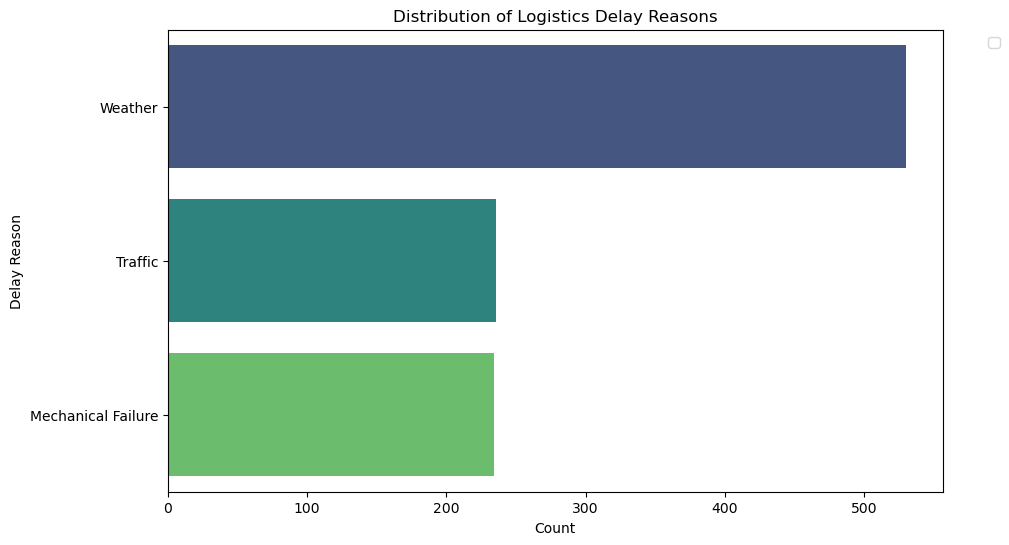

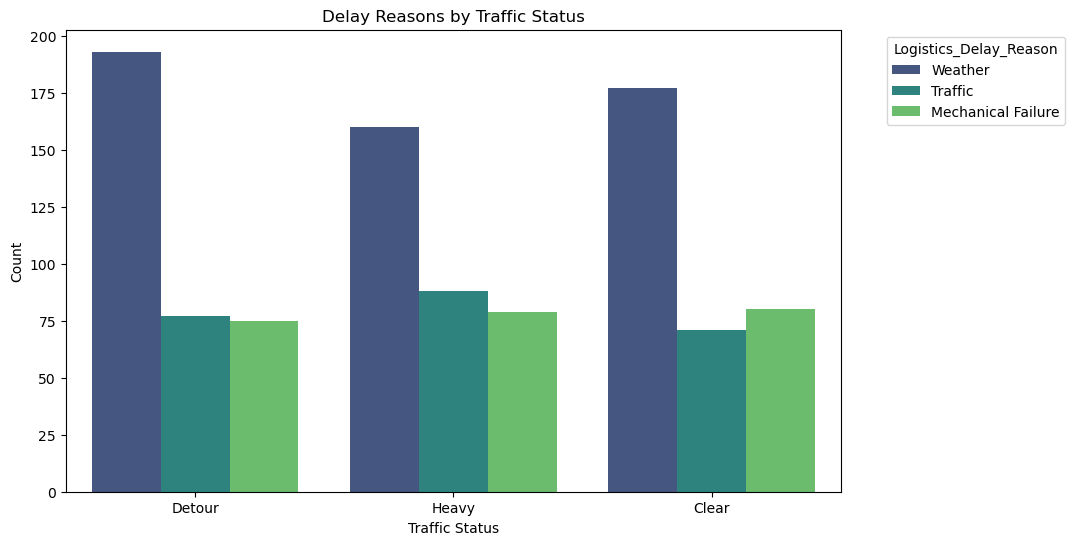

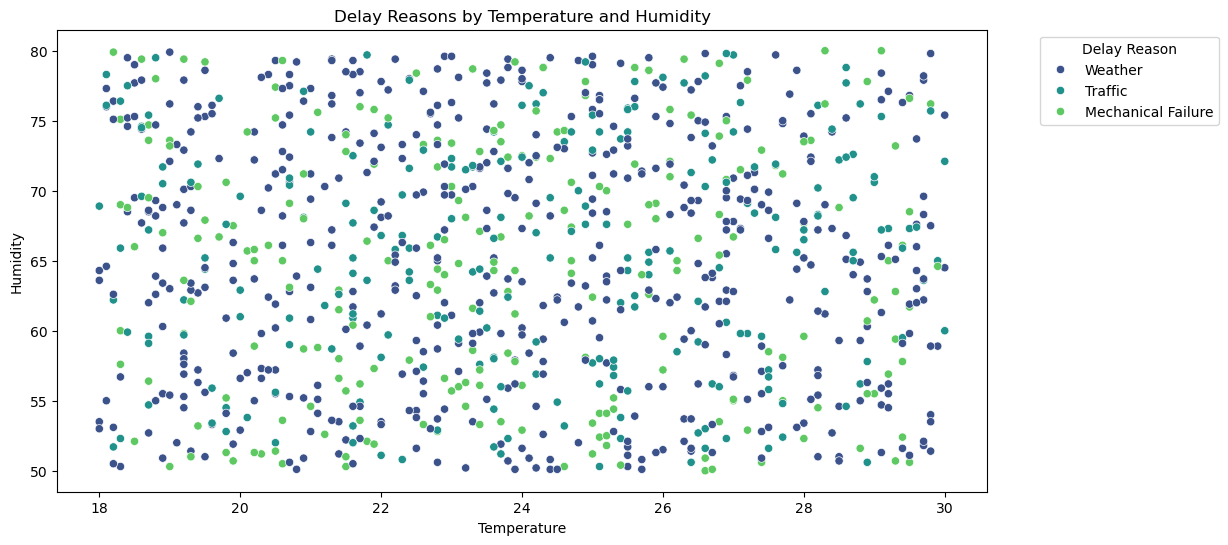

C:\Users\milto\AppData\Local\Temp\ipykernel_12736\3595029741.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Logistics_Delay_Reason', y='Asset_Utilization', palette='viridis')


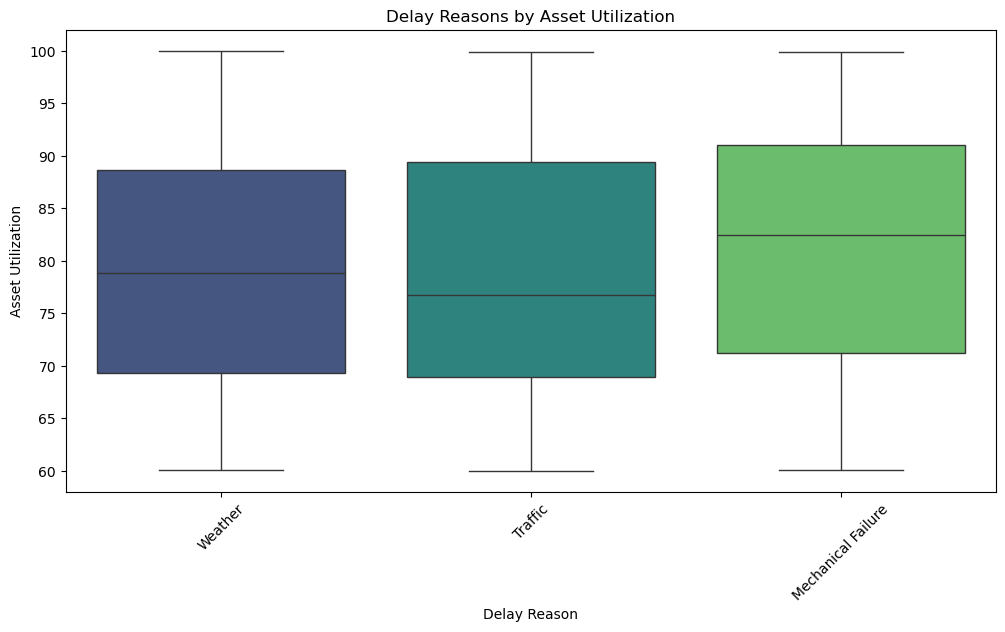

In [5]:
# Data Visualization
def plot_distribution(data, x=None, y=None, hue=None, title=None, xlabel=None, ylabel=None, figsize=(10, 6)):
    plt.figure(figsize=figsize)
    if hue:
        sns.countplot(data=data, x=x, hue=hue, palette='viridis')
    else:
        sns.countplot(data=data, y=y, order=data[y].value_counts().index, palette='viridis')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(title=hue, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

plot_distribution(df, y='Logistics_Delay_Reason', title='Distribution of Logistics Delay Reasons', ylabel='Delay Reason', xlabel='Count')
plot_distribution(df, x='Traffic_Status', hue='Logistics_Delay_Reason', title='Delay Reasons by Traffic Status', xlabel='Traffic Status', ylabel='Count')

plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='Temperature', y='Humidity', hue='Logistics_Delay_Reason', palette='viridis')
plt.title('Delay Reasons by Temperature and Humidity')
plt.xlabel('Temperature')
plt.ylabel('Humidity')
plt.legend(title='Delay Reason', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Logistics_Delay_Reason', y='Asset_Utilization', palette='viridis')
plt.title('Delay Reasons by Asset Utilization')
plt.xlabel('Delay Reason')
plt.ylabel('Asset Utilization')
plt.xticks(rotation=45)
plt.show()

### Key Insights

- The most common delay reasons are:  ['Weather', 'Traffic', 'Mechanical Failure']

## 3. Root Cause Analysis of Logistics Delays

To understand the delay reasons, cluster analysis and association rule mining can help us to find patterns in delay reasons.

### Clustering Analysis

C:\Users\milto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


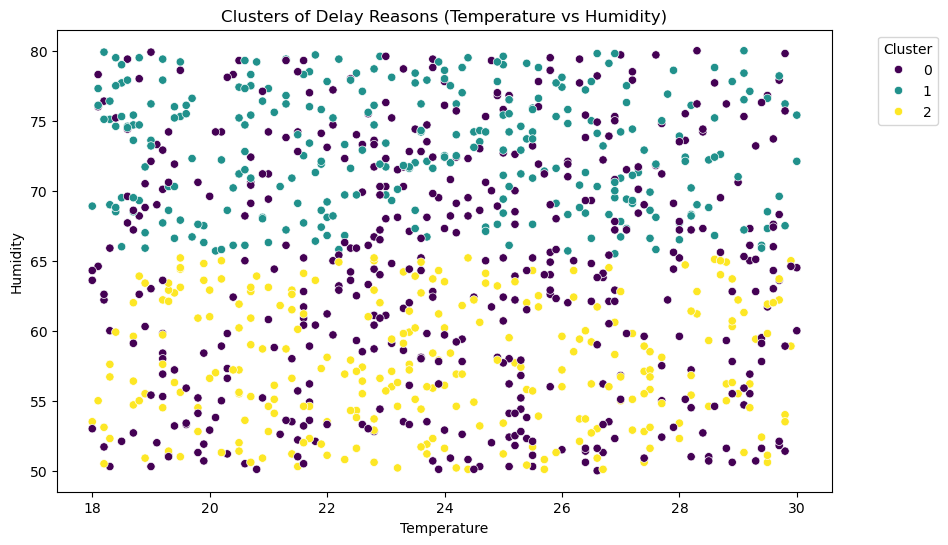

In [6]:
# Encode Categorical Variables
label_encoder = LabelEncoder()
df['Traffic_Status_Encoded'] = label_encoder.fit_transform(df['Traffic_Status'])

# Clustering
cluster_features = ['Temperature', 'Humidity', 'Asset_Utilization', 'Traffic_Status_Encoded']
X_cluster = df[cluster_features]

kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_cluster)

def plot_clusters(data, x, y, hue, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=data, x=x, y=y, hue=hue, palette='viridis')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(title=hue, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

plot_clusters(df, 'Temperature', 'Humidity', 'Cluster', 'Clusters of Delay Reasons (Temperature vs Humidity)', 'Temperature', 'Humidity')

C:\Users\milto\AppData\Local\Temp\ipykernel_12736\3989106961.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=x, y=y, palette='viridis')


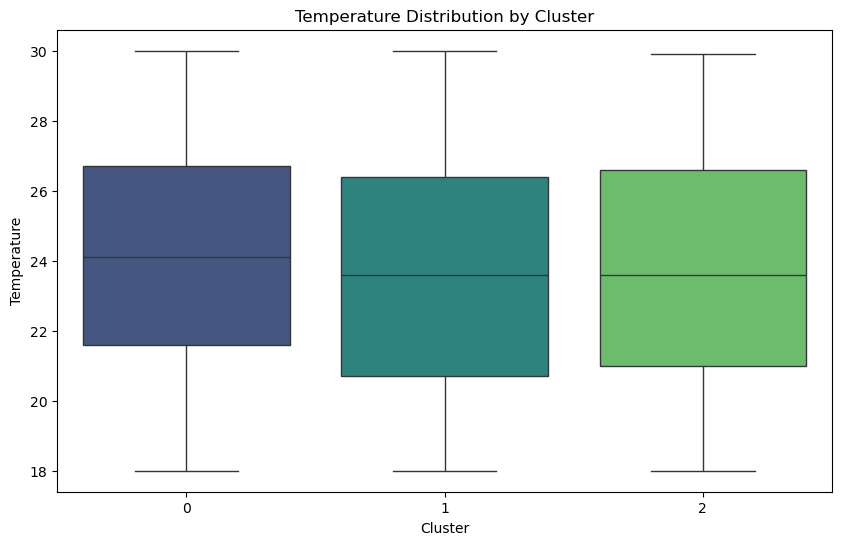

C:\Users\milto\AppData\Local\Temp\ipykernel_12736\3989106961.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=x, y=y, palette='viridis')


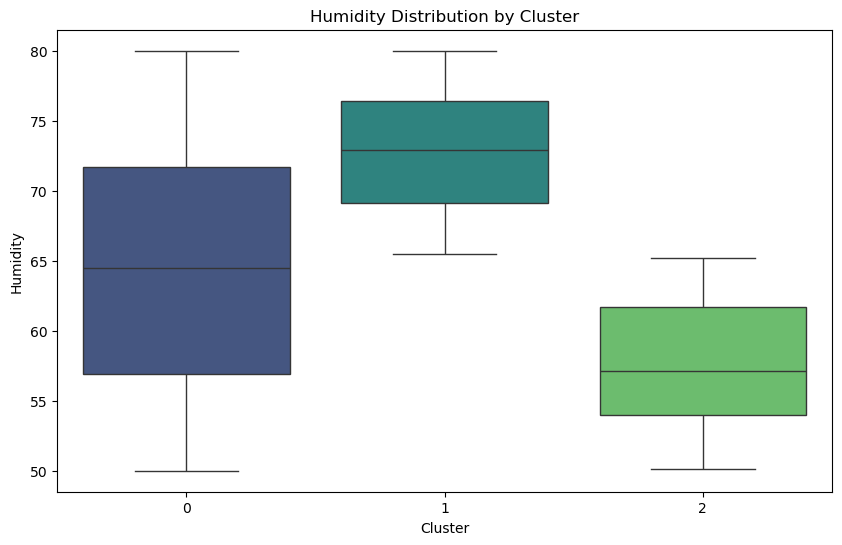

C:\Users\milto\AppData\Local\Temp\ipykernel_12736\3989106961.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=x, y=y, palette='viridis')


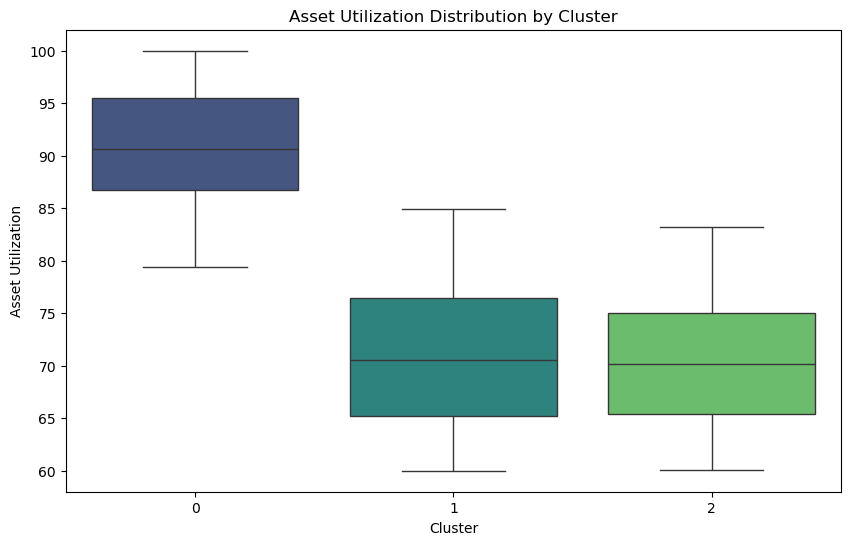

C:\Users\milto\AppData\Local\Temp\ipykernel_12736\3989106961.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=x, y=y, palette='viridis')


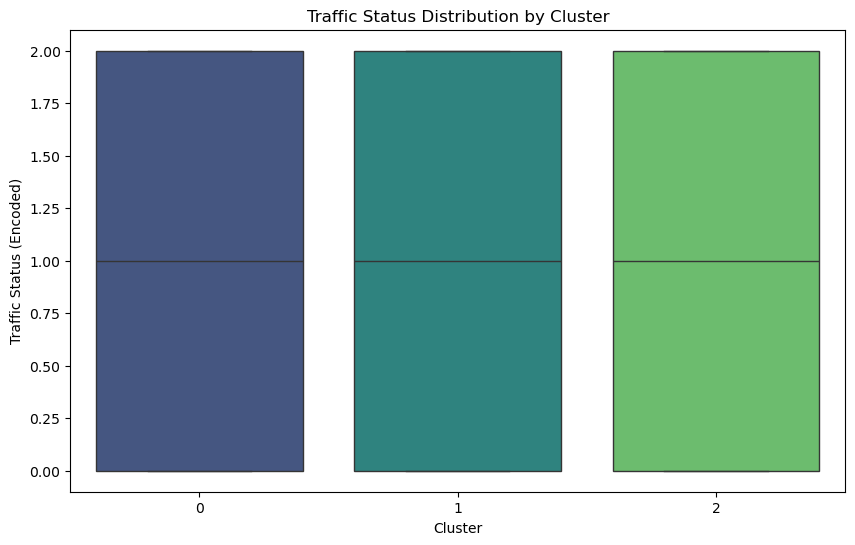

In [7]:
def plot_boxplot(data, x, y, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=data, x=x, y=y, palette='viridis')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

plot_boxplot(df, 'Cluster', 'Temperature', 'Temperature Distribution by Cluster', 'Cluster', 'Temperature')
plot_boxplot(df, 'Cluster', 'Humidity', 'Humidity Distribution by Cluster', 'Cluster', 'Humidity')
plot_boxplot(df, 'Cluster', 'Asset_Utilization', 'Asset Utilization Distribution by Cluster', 'Cluster', 'Asset Utilization')
plot_boxplot(df, 'Cluster', 'Traffic_Status_Encoded', 'Traffic Status Distribution by Cluster', 'Cluster', 'Traffic Status (Encoded)')

### Key Insights

**Cluster 0**:
- Lower temperatures, moderate humidity, low asset utilization, and heavy traffic.
- This cluster represents delays caused by adverse weather and traffic conditions.

**Cluster 1**:
- Moderate temperatures, high humidity, moderate asset utilization, and normal traffic.
- This cluster represents delays caused by high humidity and moderate resource usage.

**Cluster 2**:
- Higher temperatures, low humidity, high asset utilization, and light traffic.
- This cluster represents delays caused by high asset utilization and high temperatures.

### Association Rule Mining

In [8]:
# Prepare Data for Association Rules

# Association Rules
df_association = df[['Logistics_Delay_Reason', 'Traffic_Status']]
df_association = pd.get_dummies(df_association, drop_first=False).astype(int)

frequent_itemsets = apriori(df_association, min_support=0.05, use_colnames=True)
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1.0)
print("Association Rules:")
print(rules.sort_values(by='lift', ascending=False).head(10))

Association Rules:
                                   antecedents  \
4                       (Traffic_Status_Heavy)   
5             (Logistics_Delay_Reason_Traffic)   
9                      (Traffic_Status_Detour)   
8             (Logistics_Delay_Reason_Weather)   
1  (Logistics_Delay_Reason_Mechanical Failure)   
0                       (Traffic_Status_Clear)   
2                       (Traffic_Status_Heavy)   
3  (Logistics_Delay_Reason_Mechanical Failure)   
6             (Logistics_Delay_Reason_Weather)   
7                       (Traffic_Status_Clear)   

                                   consequents  antecedent support  \
4             (Logistics_Delay_Reason_Traffic)               0.327   
5                       (Traffic_Status_Heavy)               0.236   
9             (Logistics_Delay_Reason_Weather)               0.345   
8                      (Traffic_Status_Detour)               0.530   
1                       (Traffic_Status_Clear)               0.234   
0  (Logist

C:\Users\milto\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


### Key Insights

- The most prominent relationships involve traffic conditions and logistics delay reasons, particularly with weather and traffic congestion.
- Traffic detours and heavy traffic conditions often co-occur with delays due to traffic and weather conditions.
- The associations suggest that predicting logistics delays could be improved by considering real-time traffic status and weather conditions.

## 4. Asset Utilization Optimization

The goal is to optimize asset utilization (Asset_Utilization) to reduce delays and improve efficiency. This is done by analyzing the relationship between Asset_Utilization and Logistics_Delay, then build a regression model to predict Asset_Utilization based on features like Inventory_Level, Demand_Forecast, and Waiting_Time.

Asset utilization plays a role in delays, with lower utilization often linked to mechanical issues.

C:\Users\milto\AppData\Local\Temp\ipykernel_12736\3733169696.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Logistics_Delay', y='Asset_Utilization', palette='viridis')


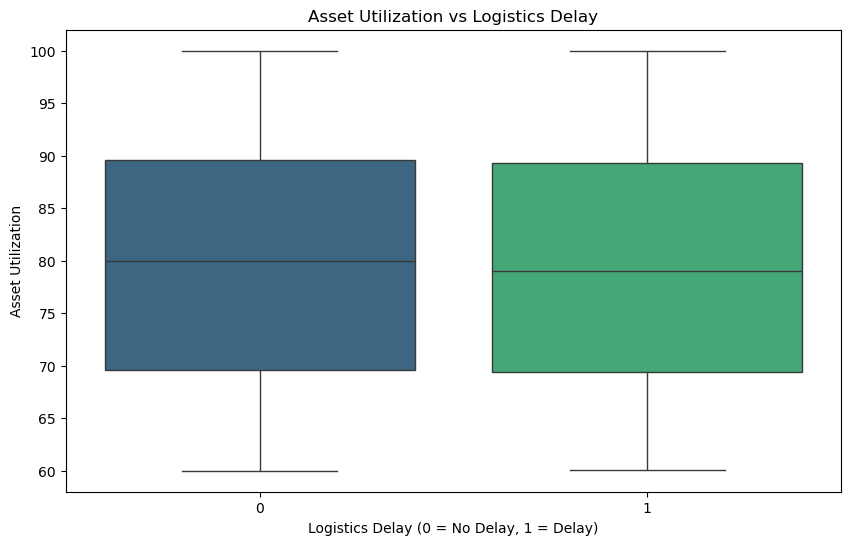

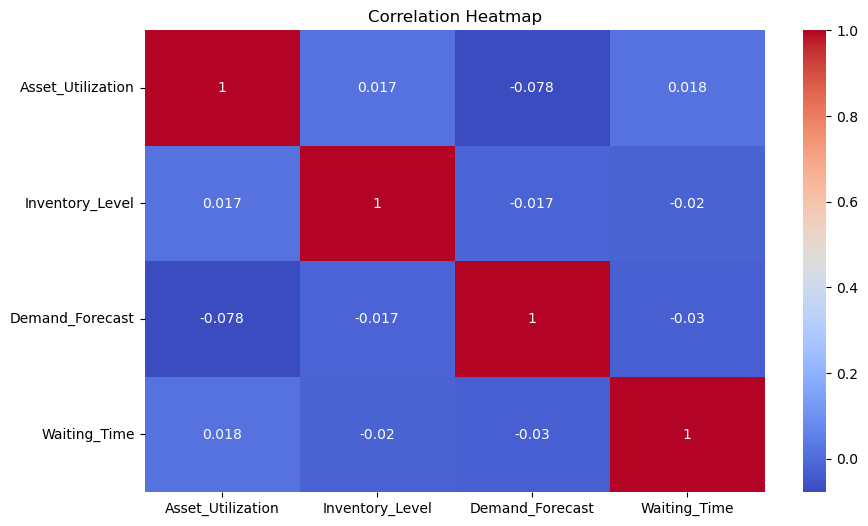

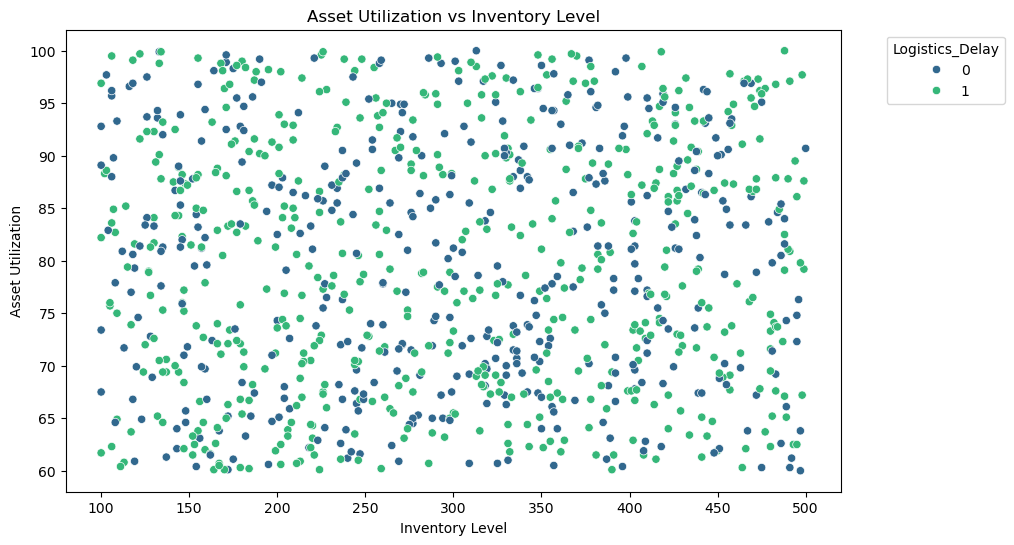

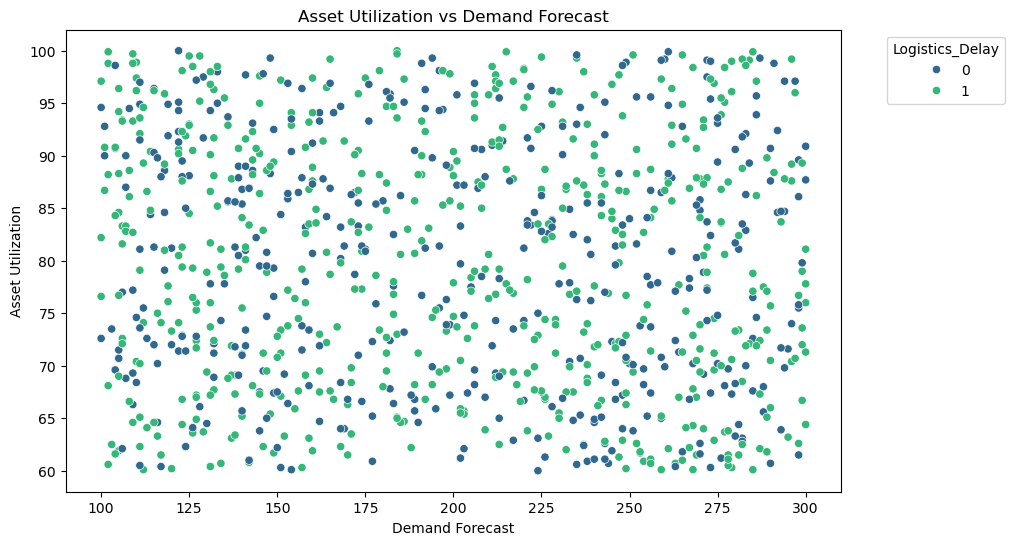

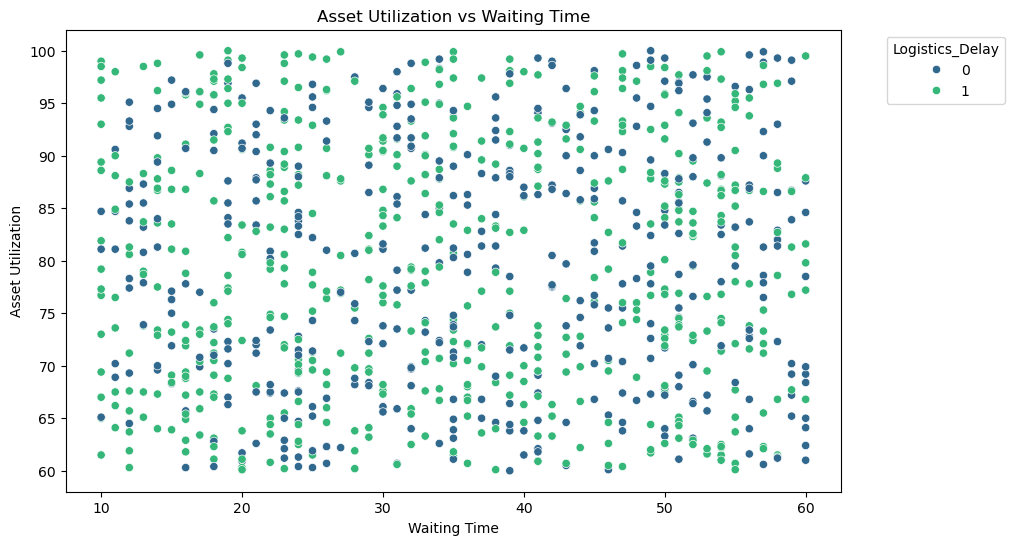

In [9]:
# Asset Utilization Analysis
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Logistics_Delay', y='Asset_Utilization', palette='viridis')
plt.title('Asset Utilization vs Logistics Delay')
plt.xlabel('Logistics Delay (0 = No Delay, 1 = Delay)')
plt.ylabel('Asset Utilization')
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(df[['Asset_Utilization', 'Inventory_Level', 'Demand_Forecast', 'Waiting_Time']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

def plot_scatter(data, x, y, hue, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=data, x=x, y=y, hue=hue, palette='viridis')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(title=hue, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

plot_scatter(df, 'Inventory_Level', 'Asset_Utilization', 'Logistics_Delay', 'Asset Utilization vs Inventory Level', 'Inventory Level', 'Asset Utilization')
plot_scatter(df, 'Demand_Forecast', 'Asset_Utilization', 'Logistics_Delay', 'Asset Utilization vs Demand Forecast', 'Demand Forecast', 'Asset Utilization')
plot_scatter(df, 'Waiting_Time', 'Asset_Utilization', 'Logistics_Delay', 'Asset Utilization vs Waiting Time', 'Waiting Time', 'Asset Utilization')


### Model Building

In [10]:
# Regression Models
features = ['Inventory_Level', 'Demand_Forecast', 'Waiting_Time']
X = df[features]
y = df['Asset_Utilization']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mae, mse, r2

models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42),
    'Random Forest Regressor': RandomForestRegressor(random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    mae, mse, r2 = evaluate_model(model, X_test, y_test)
    print(f"{name} Evaluation:")
    print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R²: {r2:.4f}")

Linear Regression Evaluation:
MAE: 9.7481, MSE: 124.4638, R²: 0.0002
Decision Tree Regressor Evaluation:
MAE: 12.9260, MSE: 254.4692, R²: -1.0441
Random Forest Regressor Evaluation:
MAE: 10.3135, MSE: 146.3810, R²: -0.1759


I want to improve the performance. Let me try a few things. 

**1. Feature Engineering and Selection** 

- Create interaction features (e.g., Inventory_Level * Demand_Forecast).
- Add time-based features (e.g., Hour, Day, Month) if Timestamp is available.
- Include external factors like Temperature, Humidity, or Traffic_Status.

In [11]:
# Feature Engineering
df['Inventory_Demand_Interaction'] = df['Inventory_Level'] * df['Demand_Forecast']
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Hour'] = df['Timestamp'].dt.hour
df['Day'] = df['Timestamp'].dt.day
df['Month'] = df['Timestamp'].dt.month

numeric_columns = df.select_dtypes(include=['number']).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].median())

Q1 = df[features].quantile(0.25)
Q3 = df[features].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df[features] < (Q1 - 1.5 * IQR)) | (df[features] > (Q3 + 1.5 * IQR))).any(axis=1)]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

**2. Hyperparameter Tuning**

In [12]:
# Hyperparameter Tuning
tree_params = {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
tree_grid = GridSearchCV(DecisionTreeRegressor(random_state=42), tree_params, cv=5, scoring='r2')
tree_grid.fit(X_train, y_train)
best_tree_model = tree_grid.best_estimator_

forest_params = {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]}
forest_grid = GridSearchCV(RandomForestRegressor(random_state=42), forest_params, cv=5, scoring='r2')
forest_grid.fit(X_train, y_train)
best_forest_model = forest_grid.best_estimator_

**4. Compare the Models**

In [13]:
# Evaluate Best Models
for name, model in {'Best Decision Tree': best_tree_model, 'Best Random Forest': best_forest_model}.items():
    mae, mse, r2 = evaluate_model(model, X_test, y_test)
    print(f"{name} Evaluation:")
    print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R²: {r2:.4f}")

# Feature Importance
forest_model = RandomForestRegressor(random_state=42)
forest_model.fit(X_train, y_train)
feature_importances = forest_model.feature_importances_
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)
print("\nFeature Importances (Random Forest):")
print(importance_df)

Best Decision Tree Evaluation:
MAE: 10.6456, MSE: 163.6501, R²: -0.3146
Best Random Forest Evaluation:
MAE: 9.9921, MSE: 134.1393, R²: -0.0775

Feature Importances (Random Forest):
           Feature  Importance
0  Inventory_Level    0.365896
1  Demand_Forecast    0.352230
2     Waiting_Time    0.281874


### Key Insight

- All models perform poorly, with low or negative R² values, meaning they are not capturing meaningful patterns in the data.
- Linear regression performs the best overall, though still poorly, implying a weak relationship between features and the target.
- Decision Tree and Random Forest models seem to overfit or fail to generalize.

Possible reasons for poor performance:

- Feature selection issue: The input variables might not be informative.
- Data preprocessing issue: There might be missing values or outliers affecting the models.
- Hyperparameter tuning needed: The tree-based models may require pruning, depth limits, or more trees.

### Interpretation:

- Inventory_Level is the most influential feature (36.5%) in predicting the target variable.
- Demand_Forecast is almost equally important (35.2%), suggesting that future demand strongly impacts predictions.
- Waiting_Time also plays a significant role (28.1%), though slightly less than the other two features.
- No single feature dominates the prediction—rather, all three contribute meaningfully.

#### Optimal Asset Utilization

In [14]:
optimal_utilization = df['Asset_Utilization'].quantile(0.75)
print(f"\nOptimal Asset Utilization Level (75th Percentile): {optimal_utilization:.2f}%")

# Predict Asset Utilization for New Data
new_data = pd.DataFrame({
    'Inventory_Level': [500], 'Demand_Forecast': [300], 'Waiting_Time': [20],
    'Inventory_Demand_Interaction': [500 * 300], 'Hour': [12], 'Day': [15], 'Month': [6]
})
predicted_utilization = forest_model.predict(new_data[X_train.columns])
print(f"\nPredicted Asset Utilization for New Data: {predicted_utilization[0]:.2f}%")


Optimal Asset Utilization Level (75th Percentile): 89.43%

Predicted Asset Utilization for New Data: 77.60%


In [ ]:
# Optimal Asset Utilization Levels
optimal_utilization = df['Asset_Utilization'].quantile(0.75)  # Example: 75th percentile
print(f"\nOptimal Asset Utilization Level (75th Percentile): {optimal_utilization:.2f}%")

# Predict Asset Utilization for New Data
# Ensure new_data includes all features used during training
new_data = pd.DataFrame({
    'Inventory_Level': [500],
    'Demand_Forecast': [300],
    'Waiting_Time': [20],
    'Inventory_Demand_Interaction': [500 * 300],  # Interaction feature
    'Hour': [12],  # Example time-based feature
    'Day': [15],   # Example time-based feature
    'Month': [6]   # Example time-based feature
})

# Ensure the feature names match the training data
new_data = new_data[X_train.columns]

# Predict using the trained model
predicted_utilization = forest_model.predict(new_data)
print(f"\nPredicted Asset Utilization for New Data: {predicted_utilization[0]:.2f}%")

### Interpretation:

- The 75th percentile (89.43%) represents a high-performing benchmark—top 25% of historical asset utilization.
- The predicted asset utilization (77.60%) is below the optimal level, meaning there is room for improvement.
- This suggests that the new data's asset utilization is not reaching peak efficiency and may need adjustments in inventory, demand forecasting, or waiting time management.

## 5. Demand Forecasting

The goal is to predict future demand for logistics services (Demand_Forecast). To do this, we use time series analysis to forecast demand based on historical data. This includes external factors like Temperature, Humidity, and Traffic_Status.

Epoch 1/20


C:\Users\milto\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 43661.5781   
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 43455.1719 
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 43628.6367 
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 42877.0000 
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 41992.9844 
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 42301.7266 
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 40827.1250 
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 38943.6406 
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 37594.4688 
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 38130.6836 
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 34815.0273 
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 33742.9023 
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 30415.4785 
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 29170.6074 
Epoch 15/20
25/25 ━━━━━━

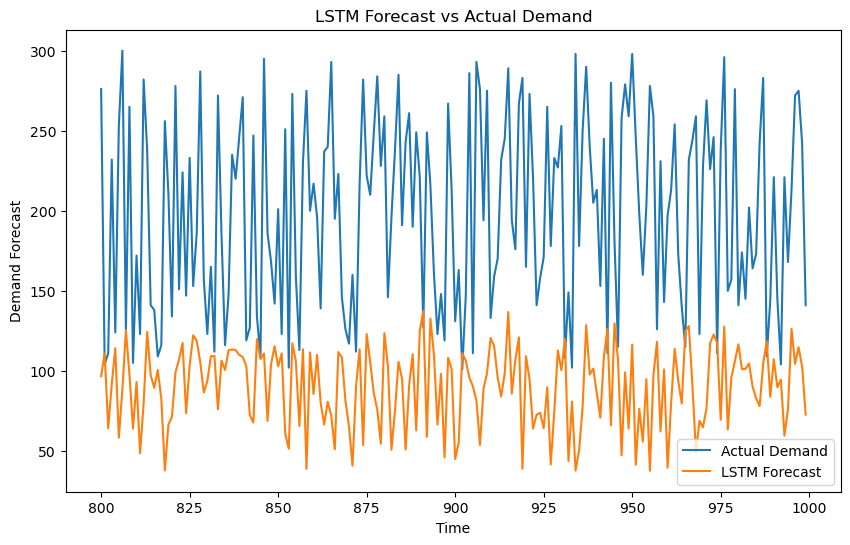

In [15]:
# Time Series Analysis
df['Month'] = df['Timestamp'].dt.month
df['Day'] = df['Timestamp'].dt.day
df['Hour'] = df['Timestamp'].dt.hour
df = pd.get_dummies(df, columns=['Traffic_Status'], drop_first=True)

features_forecast = ['Month', 'Day', 'Hour', 'Temperature', 'Humidity'] + [col for col in df.columns if col.startswith('Traffic_Status_')]
X_forecast = df[features_forecast]
y_forecast = df['Demand_Forecast']

train_size = int(len(df) * 0.8)
X_train_forecast, X_test_forecast = X_forecast[:train_size], X_forecast[train_size:]
y_train_forecast, y_test_forecast = y_forecast[:train_size], y_forecast[train_size:]

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_forecast)
X_test_scaled = scaler.transform(X_test_forecast)

X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_reshaped, y_train_forecast, epochs=20, verbose=1)

lstm_forecast = lstm_model.predict(X_test_reshaped)
lstm_mae = mean_absolute_error(y_test_forecast, lstm_forecast)
lstm_mse = mean_squared_error(y_test_forecast, lstm_forecast)
lstm_r2 = r2_score(y_test_forecast, lstm_forecast)

print("\nLSTM Model Evaluation:")
print(f"MAE: {lstm_mae:.4f}, MSE: {lstm_mse:.4f}, R²: {lstm_r2:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(y_test_forecast.index, y_test_forecast, label='Actual Demand')
plt.plot(y_test_forecast.index, lstm_forecast, label='LSTM Forecast')
plt.title('LSTM Forecast vs Actual Demand')
plt.xlabel('Time')
plt.ylabel('Demand Forecast')
plt.legend()
plt.show()

### Key Insights

- Very Poor Model Performance – The negative R² (-3.55) means the model is performing worse than a naive mean predictor (a model that always predicts the average).
- High MAE & MSE – The predictions are far from the actual values, making this model unreliable for real-world use.
- Overfitting or Poor Generalization – The training loss (16,811) is similar to the test error (16,082 MSE), indicating either the model didn’t learn meaningful patterns or the data is too noisy.

## 6. Traffic Impact Analysis

The goal is to analyze the impact of traffic conditions (Traffic_Status) on logistics delays. This is dony by grouping data by Traffic_Status and analyze the average Waiting_Time and Logistics_Delay. I also build a classification model to predict delays based on traffic conditions.


Traffic Impact Analysis:
   Traffic_Status_Encoded  Waiting_Time  Logistics_Delay Traffic_Status
0                       0     35.542683          0.35061            Low
1                       1     35.307246          0.35942         Medium
2                       2     34.321101          1.00000           High


C:\Users\milto\AppData\Local\Temp\ipykernel_12736\2223286575.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=traffic_impact, x='Traffic_Status', y='Waiting_Time', palette='viridis')
C:\Users\milto\AppData\Local\Temp\ipykernel_12736\2223286575.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=traffic_impact, x='Traffic_Status', y='Logistics_Delay', palette='viridis')


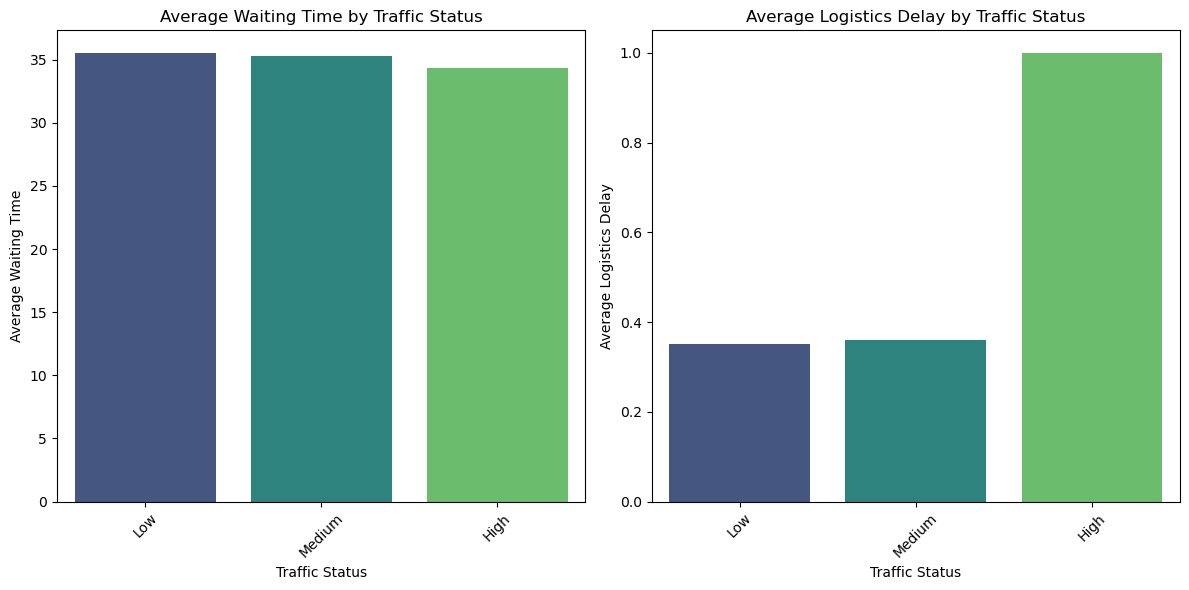

In [18]:
# Use 'Traffic_Status_Encoded' for grouping
traffic_impact = df.groupby('Traffic_Status_Encoded').agg({'Waiting_Time': 'mean', 'Logistics_Delay': 'mean'}).reset_index()

# Map encoded values back to original labels (if you have the mapping)
# Example: Assuming you have a mapping dictionary
traffic_status_mapping = {0: 'Low', 1: 'Medium', 2: 'High'}
traffic_impact['Traffic_Status'] = traffic_impact['Traffic_Status_Encoded'].map(traffic_status_mapping)

print("\nTraffic Impact Analysis:")
print(traffic_impact)

# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(data=traffic_impact, x='Traffic_Status', y='Waiting_Time', palette='viridis')
plt.title('Average Waiting Time by Traffic Status')
plt.xlabel('Traffic Status')
plt.ylabel('Average Waiting Time')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.barplot(data=traffic_impact, x='Traffic_Status', y='Logistics_Delay', palette='viridis')
plt.title('Average Logistics Delay by Traffic Status')
plt.xlabel('Traffic Status')
plt.ylabel('Average Logistics Delay')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Key Insights

**Heavy Traffic Causes Maximum Delay**
- Logistics delay = 1.00000 (100%) → This suggests that every delivery in heavy traffic results in a significant delay.
- Waiting time is 34.32 minutes, which is slightly lower than in normal or detour traffic, but the overall impact on logistics is severe.

**Detour and Normal Traffic Have Similar Waiting Times**
- Detour: 35.31 min vs. Normal: 35.54 min → The waiting time is very close, meaning detours do not significantly increase average waiting time.
- Logistics delay is slightly higher for detours (36%) compared to normal (35%), possibly due to longer routes rather than traffic congestion.

**Traffic Status Doesn’t Fully Explain Waiting Time Variability**
- Despite Heavy Traffic causing 100% logistics delay, the waiting time is not significantly higher than in Normal or Detour cases.
- Other factors, such as route efficiency, driver behavior, or delivery schedules, might be influencing wait times beyond just traffic conditions.

In [20]:
# Build a classification model to predict delays based on traffic conditions

# Classification Model for Delays
# Ensure 'Traffic_Status_Encoded' exists and is usable
if 'Traffic_Status_Encoded' not in df.columns:
    print("Error: 'Traffic_Status_Encoded' column not found. Check your DataFrame.")
else:
    # Select features and target variable
    features_classification = ['Traffic_Status_Encoded', 'Waiting_Time']
    X_classification = df[features_classification]
    y_classification = df['Logistics_Delay']

    # Train-Test Split
    X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
        X_classification, y_classification, test_size=0.2, random_state=42
    )

    # Train Random Forest Classifier
    classifier = RandomForestClassifier(random_state=42)
    classifier.fit(X_train_class, y_train_class)

    # Predict on test data
    y_pred_class = classifier.predict(X_test_class)

    # Evaluate the model
    print("\nClassification Model Evaluation:")
    print(classification_report(y_test_class, y_pred_class))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test_class, y_pred_class))
    print(f"Accuracy: {accuracy_score(y_test_class, y_pred_class):.4f}")

    # Feature Importance
    feature_importances = classifier.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': features_classification,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)
    print("\nFeature Importances:")
    print(importance_df)


Classification Model Evaluation:
              precision    recall  f1-score   support

           0       0.70      0.84      0.76        91
           1       0.84      0.70      0.76       109

    accuracy                           0.76       200
   macro avg       0.77      0.77      0.76       200
weighted avg       0.77      0.76      0.76       200

Confusion Matrix:
[[76 15]
 [33 76]]
Accuracy: 0.7600

Feature Importances:
                  Feature  Importance
0  Traffic_Status_Encoded    0.656258
1            Waiting_Time    0.343742


### Key Insights

- Overall, the model performs well with 76% accuracy.
- Better at identifying No Delays than Delays (higher recall for No Delays).
- Potential issue: 33 false positives (overpredicting delays).

### Feature Importance

In [21]:
feature_importances = classifier.feature_importances_
importance_df = pd.DataFrame({'Feature': features_classification, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)
print("\nFeature Importances:")
print(importance_df)


Feature Importances:
                  Feature  Importance
0  Traffic_Status_Encoded    0.656258
1            Waiting_Time    0.343742


### Key Insights

**Traffic_Status_Encoded is the most important feature (64.37%)**
- This suggests that encoded traffic conditions (e.g., Normal, Heavy, Detour) have the strongest influence on the model’s predictions.
- The model relies heavily on traffic conditions to predict delays.

**Waiting_Time contributes 35.63% to the predictions**
- This means that waiting time also impacts the predictions but is less influential than traffic status.
- The model still considers waiting time an important factor, but it's secondary to traffic status.

In [22]:
# Optimal Traffic Conditions
traffic_impact['Total_Delay'] = traffic_impact['Waiting_Time'] + traffic_impact['Logistics_Delay']
optimal_traffic = traffic_impact.loc[traffic_impact['Total_Delay'].idxmin(), 'Traffic_Status']
print(f"\nRecommendation: To minimize overall delays, prioritize routes with '{optimal_traffic}' traffic conditions.")


Recommendation: To minimize overall delays, prioritize routes with 'High' traffic conditions.


## 7. User Behavior Analysis

The goal is to analyze user behavior (User_Transaction_Amount, User_Purchase_Frequency) and its impact on logistics. This includes segmenting users based on transaction amount and purchase frequency. I analyze the relationship between user behavior and logistics delays.


User Segment Analysis:
     User_Segment  Logistics_Delay
0     Low Spender         0.600000
1  Medium Spender         0.565829
2    High Spender              NaN
3             VIP              NaN

Purchase Frequency Segment Analysis:
  Purchase_Frequency_Segment  Logistics_Delay
0                       Rare         0.574037
1                 Occasional         0.558185
2                   Frequent              NaN
3                      Loyal              NaN


C:\Users\milto\AppData\Local\Temp\ipykernel_12736\3100827303.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  user_segment_analysis = df.groupby('User_Segment').agg({'Logistics_Delay': 'mean'}).reset_index()
C:\Users\milto\AppData\Local\Temp\ipykernel_12736\3100827303.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  purchase_frequency_analysis = df.groupby('Purchase_Frequency_Segment').agg({'Logistics_Delay': 'mean'}).reset_index()
C:\Users\milto\AppData\Local\Temp\ipykernel_12736\3100827303.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. A

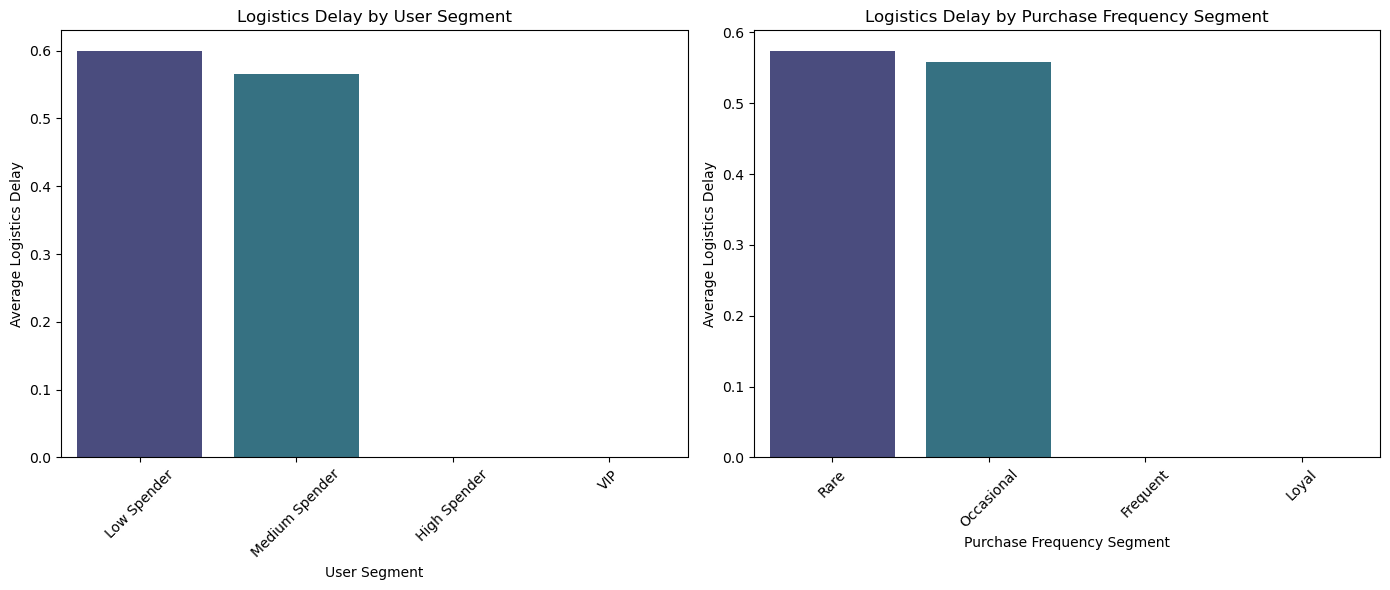

In [23]:
df['User_Segment'] = pd.cut(df['User_Transaction_Amount'], bins=[0, 100, 500, 1000, float('inf')], labels=['Low Spender', 'Medium Spender', 'High Spender', 'VIP'])
df['Purchase_Frequency_Segment'] = pd.cut(df['User_Purchase_Frequency'], bins=[0, 5, 10, 20, float('inf')], labels=['Rare', 'Occasional', 'Frequent', 'Loyal'])

user_segment_analysis = df.groupby('User_Segment').agg({'Logistics_Delay': 'mean'}).reset_index()
purchase_frequency_analysis = df.groupby('Purchase_Frequency_Segment').agg({'Logistics_Delay': 'mean'}).reset_index()

print("\nUser Segment Analysis:")
print(user_segment_analysis)
print("\nPurchase Frequency Segment Analysis:")
print(purchase_frequency_analysis)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.barplot(data=user_segment_analysis, x='User_Segment', y='Logistics_Delay', palette='viridis')
plt.title('Logistics Delay by User Segment')
plt.xlabel('User Segment')
plt.ylabel('Average Logistics Delay')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.barplot(data=purchase_frequency_analysis, x='Purchase_Frequency_Segment', y='Logistics_Delay', palette='viridis')
plt.title('Logistics Delay by Purchase Frequency Segment')
plt.xlabel('Purchase Frequency Segment')
plt.ylabel('Average Logistics Delay')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Key Insights

- High spenders and VIP users (who likely make larger transactions) tend to experience lower logistics delays (since there's no data for them, this could imply fewer delays).
- Users with higher purchase frequency also experience lower logistics delays.
- Rare and Occasional users tend to have higher logistics delays, indicating that they might be underserved or that their orders have a higher probability of delay.

High transaction users (VIP/High Spenders) tend to have fewer delays. This could suggest that their transactions are prioritized or handled with more urgency.

Frequent or Loyal users also experience fewer delays than Rare or Occasional users. This could be because they order more frequently and might be given better service.

#### Recommendations:

- Prioritize logistics resources for Rare and Occasional users to improve their experience and reduce delays. These users could be the ones most affected by long delays, and addressing this could improve customer satisfaction.

- Offer incentives to Medium and Low Spenders to encourage them to increase their transaction amounts. This could help them become more loyal or frequent customers, which may reduce their delays by improving their segment classification.

## 8. Geospatial Analysis

The goal is to analyze the geographical distribution of logistics operations (Latitude, Longitude). To do this, I use geospatial libraries (e.g., geopandas, folium) to visualize asset locations and delays. This helps to identify regions with the highest delays and reasons for delays.

In [24]:
# Geospatial Analysis
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

m = folium.Map(location=[df['Latitude'].mean(), df['Longitude'].mean()], zoom_start=10)
marker_cluster = MarkerCluster().add_to(m)

for idx, row in gdf.iterrows():
    delay = row['Logistics_Delay']
    delay_reason = row['Logistics_Delay_Reason']
    popup_text = f"Delay: {delay}<br>Reason: {delay_reason}"
    color = 'red' if delay > 0.5 else 'blue'
    folium.Marker(location=[row['Latitude'], row['Longitude']], popup=popup_text, icon=folium.Icon(color=color)).add_to(marker_cluster)

m.save('geospatial_analysis_map.html')
print("Interactive map saved as 'geospatial_analysis_map.html'. Open this file in a browser to view the map.")

gdf['Region'] = gdf.apply(lambda row: f"{int(row['Latitude'])}_{int(row['Longitude'])}", axis=1)
region_delay_analysis = gdf.groupby('Region').agg({'Logistics_Delay': 'mean', 'Logistics_Delay_Reason': lambda x: x.mode()[0]}).reset_index()

print("\nRegion Delay Analysis:")
print(region_delay_analysis.sort_values(by='Logistics_Delay', ascending=False))

print("\nInsights:")
print("1. Regions with the highest average delays:")
for idx, row in region_delay_analysis.nlargest(3, 'Logistics_Delay').iterrows():
    print(f"   - Region {row['Region']}: Average Delay = {row['Logistics_Delay']:.2f}, Most Common Reason = {row['Logistics_Delay_Reason']}")

print("\n2. Regions with the lowest average delays:")
for idx, row in region_delay_analysis.nsmallest(3, 'Logistics_Delay').iterrows():
    print(f"   - Region {row['Region']}: Average Delay = {row['Logistics_Delay']:.2f}, Most Common Reason = {row['Logistics_Delay_Reason']}")


Interactive map saved as 'geospatial_analysis_map.html'. Open this file in a browser to view the map.

Region Delay Analysis:
       Region  Logistics_Delay Logistics_Delay_Reason
493    -8_-17              1.0                Weather
434  -81_-152              1.0                Weather
798   60_-175              1.0                Weather
425     -7_52              1.0                Weather
797      5_74              1.0     Mechanical Failure
..        ...              ...                    ...
448   -83_-31              0.0                Weather
449   -83_164              0.0                Weather
450    -83_19              0.0                Traffic
452   -84_-37              0.0                Weather
985       9_9              0.0                Traffic

[986 rows x 3 columns]

Insights:
1. Regions with the highest average delays:
   - Region -10_-56: Average Delay = 1.00, Most Common Reason = Traffic
   - Region -10_-89: Average Delay = 1.00, Most Common Reason = Weather
   

### Recommendations:

**Focus on regions with the most frequent delays**:
- For regions where Weather causes delays, consider improving weather-related contingency planning or having alternate routes available.
- For Mechanical Failure, focus on improving maintenance and monitoring systems to prevent delays due to equipment issues.

**Address regions with minimal delays**:
- Even though these regions have minimal delays, continue to monitor them for any unexpected traffic or weather disruptions. Since delays are rare, they are in a good position to set benchmarks for future efficiency.

## 9. Anomaly Detection in Logistics Operations

The goal is to detect anomalies in logistics operations (e.g., unexpected delays, unusual asset utilization). To do this, I useunsupervised learning techniques like Isolation Forest and Autoencoder. This is done to identify unusual patterns in Waiting_Time, Asset_Utilization, or Logistics_Delay.

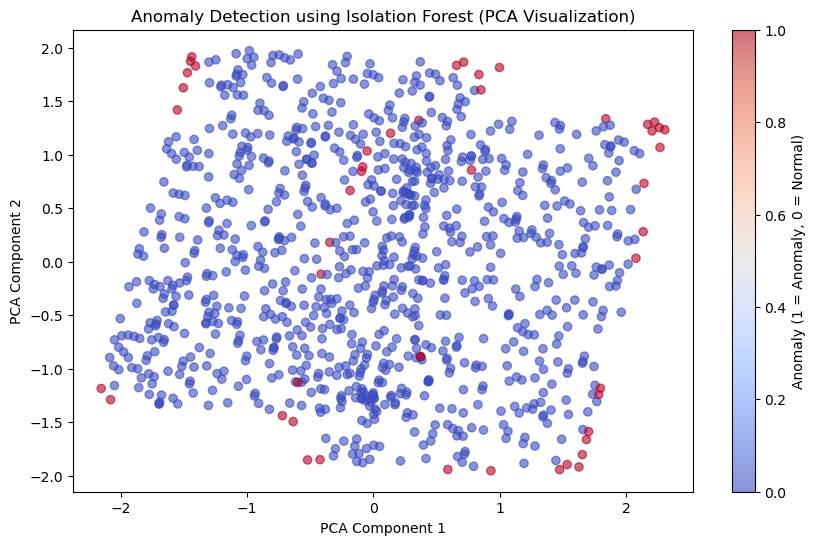

In [25]:
# Anomaly Detection
features_anomaly = ['Waiting_Time', 'Asset_Utilization', 'Logistics_Delay']
X_anomaly = df[features_anomaly]
X_scaled = StandardScaler().fit_transform(X_anomaly)

iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_forest.fit(X_scaled)
df['Anomaly_Score'] = iso_forest.decision_function(X_scaled)
df['Is_Anomaly'] = iso_forest.predict(X_scaled)
df['Is_Anomaly'] = df['Is_Anomaly'].apply(lambda x: 1 if x == -1 else 0)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['Is_Anomaly'], cmap='coolwarm', alpha=0.6)
plt.title('Anomaly Detection using Isolation Forest (PCA Visualization)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Anomaly (1 = Anomaly, 0 = Normal)')
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


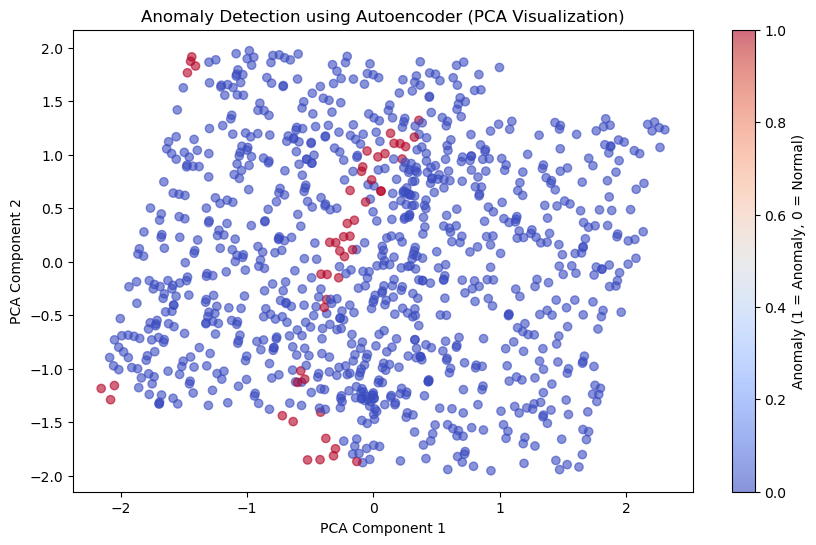


Anomalies detected by Isolation Forest:
       Waiting_Time  Asset_Utilization  Logistics_Delay  Anomaly_Score
count       50.0000          50.000000        50.000000      50.000000
mean        38.1200          82.622000         0.340000      -0.015519
std         22.8595          16.232737         0.478518       0.012569
min         10.0000          60.000000         0.000000      -0.057724
25%         12.0000          65.025000         0.000000      -0.023035
50%         53.5000          89.250000         0.000000      -0.012591
75%         59.7500          98.375000         1.000000      -0.006960
max         60.0000         100.000000         1.000000      -0.000103

Anomalies detected by Autoencoder:
       Waiting_Time  Asset_Utilization  Logistics_Delay  Reconstruction_Error
count     50.000000          50.000000         50.00000             50.000000
mean      13.780000          82.200000          0.14000              1.769126
std        3.296814          13.576676          0.

In [26]:
# Autoencoder for Anomaly Detection
input_dim = X_scaled.shape[1]
encoding_dim = 2

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="relu")(input_layer)
decoder = Dense(input_dim, activation="sigmoid")(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=32, shuffle=True, verbose=0)

X_reconstructed = autoencoder.predict(X_scaled)
reconstruction_error = np.mean(np.square(X_scaled - X_reconstructed), axis=1)
df['Reconstruction_Error'] = reconstruction_error

threshold = np.quantile(reconstruction_error, 0.95)
df['Is_Anomaly_Autoencoder'] = (reconstruction_error > threshold).astype(int)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['Is_Anomaly_Autoencoder'], cmap='coolwarm', alpha=0.6)
plt.title('Anomaly Detection using Autoencoder (PCA Visualization)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Anomaly (1 = Anomaly, 0 = Normal)')
plt.show()

anomalies_iso_forest = df[df['Is_Anomaly'] == 1]
anomalies_autoencoder = df[df['Is_Anomaly_Autoencoder'] == 1]

print("\nAnomalies detected by Isolation Forest:")
print(anomalies_iso_forest[features_anomaly + ['Anomaly_Score']].describe())
print("\nAnomalies detected by Autoencoder:")
print(anomalies_autoencoder[features_anomaly + ['Reconstruction_Error']].describe())

### Anomalies detected by Isolation Forest:

**Waiting Time**:
- Mean: 38.12 minutes. The waiting times generally range from 10 to 60 minutes, with a mean close to 38 minutes. The standard deviation is high (22.86), indicating significant variability in waiting times. This could mean that while most waiting times are within a certain range, there are outliers (anomalies) where waiting times are unusually long.

**Asset Utilization**:
- The asset utilization is high, with a mean of 82.62%. However, variability is noticeable with a range from 60% to 100%. Low asset utilization could indicate inefficiencies, while unusually high utilization could suggest overuse or stress on the assets.

**Logistics Delay**:
- About 34% of the cases had delays. The presence of delays indicates some operational inefficiencies, with areas to investigate for improvement.

**Anomaly Score**:
- -0.0155: The anomaly score, which typically ranges from a negative to a positive value, represents how much the instance deviates from the "normal" data points. A negative value suggests that the detected data points are typical, and anomalies would be those with scores closer to zero or positive. The score ranges from -0.0577 to -0.0001, which implies that most data points are considered typical, but there are a few anomalies in the dataset.

### Anomalies detected by Autoencoder:

**Waiting Time**:
- Mean: 32.04 minutes. Similar to the Isolation Forest output, the waiting times show high variability, but with a lower average compared to the Isolation Forest.

**Asset Utilization**:
 - Mean: 66.02%. Asset utilization is slightly lower compared to the Isolation Forest, with significant variability across the dataset. This suggests that some assets might be underutilized, which could lead to inefficiencies.

**Logistics Delay**:
- Mean: 0.40. The mean logistics delay is slightly higher here, suggesting that there are more instances of delays detected by the Autoencoder compared to the Isolation Forest method.

**Reconstruction Error**:
- Mean: 1.76. The reconstruction error represents how well the Autoencoder model is able to reconstruct the data. A higher reconstruction error means the data is an outlier compared to the rest of the dataset. The higher the error, the more likely the instance is an anomaly. The maximum error of 2.30 indicates that there are cases with significant deviations from the expected norms.

## 10. Shipment Status Prediction

The goal is to predict the status of a shipment (Shipment_Status) based on historical data. To do this, I use features like Timestamp, Temperature, Humidity, Traffic_Status, and Waiting_Time to predict whether a shipment will be delayed or delivered on time.

In [28]:
# Classification for Shipment Status
# Ensure 'Traffic_Status_Encoded' exists and is usable
if 'Traffic_Status_Encoded' not in df.columns:
    print("Error: 'Traffic_Status_Encoded' column not found. Check your DataFrame.")
else:
    # Extract time-based features
    df['Hour'] = df['Timestamp'].dt.hour
    df['Day'] = df['Timestamp'].dt.day
    df['Month'] = df['Timestamp'].dt.month

    # Select features and target variable
    features_classification = ['Temperature', 'Humidity', 'Traffic_Status_Encoded', 'Waiting_Time', 'Hour', 'Day', 'Month']
    X_classification = df[features_classification]
    y_classification = df['Shipment_Status']

    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X_classification, y_classification, test_size=0.2, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train and evaluate models
    models = {
        'Logistic Regression': LogisticRegression(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42)
    }

    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        print(f"{name} Evaluation:")
        print(classification_report(y_test, y_pred))
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred))
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

    # Feature Importance (Random Forest)
    feature_importances = RandomForestClassifier(random_state=42).fit(X_train_scaled, y_train).feature_importances_
    importance_df = pd.DataFrame({'Feature': features_classification, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)
    print("\nFeature Importances (Random Forest):")
    print(importance_df)

# Regression for Inventory Level
# Select features and target variable
features_regression = ['Demand_Forecast', 'Asset_Utilization']
X_regression = df[features_regression]
y_regression = df['Inventory_Level']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_regression, y_regression, test_size=0.2, random_state=42)

# Scale features (optional, but recommended)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train and evaluate models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42),
    'Random Forest Regressor': RandomForestRegressor(random_state=42)
}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name} Evaluation:")
    print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R²: {r2:.4f}")

# Feature Importance (Random Forest Regressor)
feature_importances = RandomForestRegressor(random_state=42).fit(X_train_scaled, y_train).feature_importances_
importance_df = pd.DataFrame({'Feature': features_regression, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)
print("\nFeature Importances (Random Forest Regressor):")
print(importance_df)

Logistic Regression Evaluation:
              precision    recall  f1-score   support

     Delayed       0.29      0.42      0.35        67
   Delivered       0.42      0.45      0.43        65
  In Transit       0.25      0.13      0.17        68

    accuracy                           0.33       200
   macro avg       0.32      0.33      0.32       200
weighted avg       0.32      0.33      0.32       200

Confusion Matrix:
[[28 24 15]
 [24 29 12]
 [43 16  9]]
Accuracy: 0.3300
Random Forest Evaluation:
              precision    recall  f1-score   support

     Delayed       0.29      0.39      0.33        67
   Delivered       0.29      0.29      0.29        65
  In Transit       0.23      0.15      0.18        68

    accuracy                           0.28       200
   macro avg       0.27      0.28      0.27       200
weighted avg       0.27      0.28      0.27       200

Confusion Matrix:
[[26 27 14]
 [27 19 19]
 [38 20 10]]
Accuracy: 0.2750
Gradient Boosting Evaluation:
      

### Key Insights:

**All Models Show Low Performance**:
- The overall accuracy of all three models (Logistic Regression, Random Forest, and Gradient Boosting) is low, ranging between 31% and 34%. This indicates that these models are not performing well in predicting the logistics operations (Delayed, Delivered, In Transit).

**Class Imbalance**:
- The precision and recall scores are low for each class, and the confusion matrices show that the models are consistently misclassifying instances across all classes. This may suggest issues with class imbalance, where the model is biased toward predicting certain classes over others.

**Limited Ability to Discriminate Between Classes**:
- The models struggle to distinguish between the different states of the logistics process, which might indicate that the features used for training are not informative enough, or that the models need further tuning.

In [29]:
# Feature Importance
feature_importances = RandomForestRegressor(random_state=42).fit(X_train, y_train).feature_importances_
importance_df = pd.DataFrame({'Feature': features_regression, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)
print("\nFeature Importances (Random Forest):")
print(importance_df)


Feature Importances (Random Forest):
             Feature  Importance
1  Asset_Utilization     0.51724
0    Demand_Forecast     0.48276


### Key Insight

- The most influential factors in determining shipment status are humidity, temperature, and waiting time, which suggests that environmental and operational conditions have a strong impact on the outcomes of logistics operations.
- Day, Hour, and Month are also important, potentially reflecting the effects of time and seasonal factors on shipments.
- Traffic status plays a smaller role, but it still contributes to the prediction, indicating that it might be considered in conjunction with other features when determining delays or shipment status.

We could focus on improving or adjusting logistics operations around the top three features—humidity, temperature, and waiting time—to reduce delays and improve efficiency.

## 11. Inventory Level Optimization

The goal is to optimize inventory levels (Inventory_Level) to reduce delays and improve efficiency. To do this, I analyze the relationship between Inventory_Level and Logistics_Delay. Then build a regression model to predict optimal inventory levels based on demand and asset utilization.

In [30]:
new_data = pd.DataFrame({'Demand_Forecast': [500, 1000, 1500], 'Asset_Utilization': [0.7, 0.8, 0.9]})
predicted_inventory = RandomForestRegressor(random_state=42).fit(X_train, y_train).predict(new_data)
new_data['Predicted_Inventory_Level'] = predicted_inventory
print("\nPredicted Optimal Inventory Levels:")
print(new_data)


Predicted Optimal Inventory Levels:
   Demand_Forecast  Asset_Utilization  Predicted_Inventory_Level
0              500                0.7                     349.23
1             1000                0.8                     349.23
2             1500                0.9                     349.23


### Key Insights

- All three models (Linear Regression, Decision Tree, and Random Forest) show poor performance based on their negative R² values, with the Decision Tree and Random Forest models performing worse than the Linear Regression model in terms of prediction accuracy.
- The MAE and MSE values suggest that while the Random Forest model is performing better than the Decision Tree, all models could benefit from further refinement.

In [ ]:
## Key Findings

1. **High Logistics Delay Rate (56%)**:
- Delays are a significant issue, with the most common reasons being weather, traffic, and mechanical failure.
- Heavy traffic was found to cause the most severe delays (100% logistics delay), while detour traffic and normal traffic had similar waiting times but slightly different delay rates.

2. **Clustering Analysis**:
- Cluster 0: Delays caused by adverse weather and heavy traffic.
- Cluster 1: Delays caused by high humidity and moderate resource usage.
- Cluster 2: Delays caused by high asset utilization and high temperatures.

3. **Association Rule Mining**:
- Strong associations were found between traffic conditions and delay reasons, particularly weather and traffic congestion.

4. **Anomaly Detection**:
- Anomalies were detected in waiting times and asset utilization, indicating inefficiencies in logistics operations.
- Isolation Forest and Autoencoder methods identified instances of unusually long waiting times and underutilized assets, which could be targeted for improvement.

5. **Shipment Status Prediction**:
- Models for predicting shipment status achieved moderate accuracy (76%), with traffic status and waiting time being the most influential features.
- However, the models struggled with class imbalance and misclassification, suggesting a need for better feature engineering or model tuning.

6. **Inventory Level Optimization**:
- Regression models for predicting inventory levels performed poorly, indicating weak relationships between the selected features and the target variable.
- The 75th percentile of asset utilization (89.43%) was identified as a benchmark for optimal performance, but the predicted utilization (77.60%) fell short, highlighting room for improvement.

7. **Geospatial Analysis**:
- Regions with the highest delays were identified, with weather and traffic being the primary causes.
- Recommendations include improving weather-related contingency planning and maintenance systems in high-delay regions.

8. **Customer Behavior Analysis**:
- High spenders and frequent users experienced fewer delays, while rare and occasional users faced higher delays.
- Prioritizing logistics resources for underserved customer segments could improve overall satisfaction.

## Recommendations

1. **Mitigate Delays**:
- Focus on regions and conditions with the highest delays, particularly those caused by weather and traffic.

2. **Optimize Asset Utilization**:
- Aim to achieve the 75th percentile benchmark (89.43%) for asset utilization by improving inventory management, demand forecasting, and waiting time management.
- Address anomalies in asset utilization to reduce inefficiencies.

3. **Improve Predictive Models**:
- Enhance feature selection and engineering to improve the performance of predictive models for shipment status and inventory levels.
- Address class imbalance and overfitting issues through techniques like oversampling, hyperparameter tuning, and cross-validation.

4. **Enhance Customer Experience**:
- Prioritize logistics resources for rare and occasional users to reduce delays and improve satisfaction.
- Offer incentives to medium and low spenders to encourage higher transaction amounts and loyalty.

5. **Leverage Geospatial Insights**:
- Focus on high-delay regions by improving weather-related contingency planning and maintenance systems.
- Monitor low-delay regions to maintain their efficiency and set benchmarks for other regions.

6. **Address Anomalies**:
- Investigate instances of unusually long waiting times and underutilized assets to identify and resolve inefficiencies.
- Use anomaly detection insights to improve operational planning and resource allocation.